In [55]:

## Libraries and Settings

from dataclasses import dataclass, field
from typing import Dict
import os
from pathlib import Path
import re
import yfinance as yf
import pandas as pd
import requests
import matplotlib.pyplot as plt

# Stocks variables

In [ ]:

@dataclass
class Settings:
    http_timeout: int = field(default_factory=lambda: int(os.getenv("HTTP_TIMEOUT", 30)))
    ecb_base: str = field(default_factory=lambda: os.getenv("ECB_API_BASE", "https://data-api.ecb.europa.eu/service"))
    tickers: Dict[str, str] = field(default_factory=dict)

    def __post_init__(self):
        self.tickers.update({
            "stoxx_eur_pts": os.getenv("YF_TICK_STOXX", "^STOXX50E"),
            "ibex_eur_pts":  os.getenv("YF_TICK_IBEX", "^IBEX"),
            "cac_eur_pts":   os.getenv("YF_TICK_CAC", "^FCHI"),
            "psi_eur_pts": os.getenv("YF_TICK_PSI", "PSI20.LS"),
        })
        self.tickers = {k.lower(): v for k, v in self.tickers.items() if v}

    def get_ticker(self, key: str) -> str:
        k = key.lower()
        if k not in self.tickers or not self.tickers[k]:
            raise KeyError(f"Missing ticker for '{key}'. Set YF_TICK_* env var.")
        return self.tickers[k]

settings = Settings()
settings.ecb_base, settings.get_ticker("cac_eur_pts")


('https://data-api.ecb.europa.eu/service', '^FCHI')

In [2]:

KEY = "D.USD.EUR.SP00.A"  # daily USD per EUR reference rate

def fetch_eur_usd(start: str, end: str, http_timeout: int = None) -> pd.DataFrame:
    base = settings.ecb_base.rstrip("/")
    url = (
        f"{base}/data/EXR/{KEY}"
        f"?startPeriod={start}&endPeriod={end}"
        f"&detail=dataonly&format=jsondata"
    )
    r = requests.get(url, timeout=http_timeout or settings.http_timeout)
    r.raise_for_status()
    data = r.json()

    time_vals = data["structure"]["dimensions"]["observation"][0]["values"]
    series_dict = data["dataSets"][0]["series"]
    rows = []
    for serie in series_dict.values():
        for idx_str, arr in serie.get("observations", {}).items():
            t = time_vals[int(idx_str)]["id"]
            v = arr[0]
            rows.append({"date": t, "eurusd": float(v)})

    fx = pd.DataFrame(rows)
    if fx.empty:
        return pd.DataFrame(columns=["date", "eurusd", "usdeur", "source"])

    # Normalize to tz-naive midnight
    fx["date"] = pd.to_datetime(fx["date"]).dt.normalize()

    fx = fx.sort_values("date").reset_index(drop=True)
    fx["usdeur"] = 1.0 / fx["eurusd"]
    fx["source"] = "ecb:data-api"
    return fx

fx_demo = fetch_eur_usd("2021-05-01", "2025-04-30")
fx_demo.head(), fx_demo.tail(), len(fx_demo)


(        date  eurusd    usdeur        source
 0 2021-05-03  1.2044  0.830289  ecb:data-api
 1 2021-05-04  1.2021  0.831878  ecb:data-api
 2 2021-05-05  1.2005  0.832986  ecb:data-api
 3 2021-05-06  1.2060  0.829187  ecb:data-api
 4 2021-05-07  1.2059  0.829256  ecb:data-api,
            date  eurusd    usdeur        source
 1021 2025-04-24  1.1376  0.879044  ecb:data-api
 1022 2025-04-25  1.1357  0.880514  ecb:data-api
 1023 2025-04-28  1.1358  0.880437  ecb:data-api
 1024 2025-04-29  1.1373  0.879275  ecb:data-api
 1025 2025-04-30  1.1373  0.879275  ecb:data-api,
 1026)

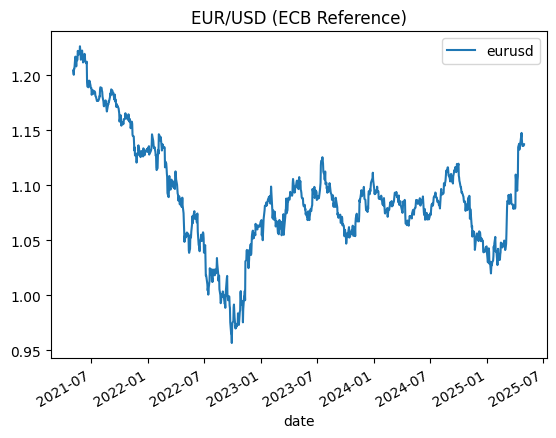

In [ ]:

if not fx_demo.empty:
    fx_demo.plot(x="date", y="eurusd", title="EUR/USD (ECB Reference)")
    plt.show()
else:
    print("ECB fetch returned empty dataframe for the given dates.")


## Fetch data from `yfinance`

In [18]:


def _normalize_dtindex_to_naive_midnight_utc(df: pd.DataFrame) -> pd.DataFrame:
    """
    Ensure df.index is tz-naive midnight (UTC-normalized day).
    """
    if not isinstance(df.index, pd.DatetimeIndex):
        return df
    # If tz-aware, convert to UTC
    if df.index.tz is not None:
        df = df.tz_convert("UTC")
    # Drop tz & floor to day
    df.index = df.index.tz_localize(None).normalize()
    return df

def fetch_brent(start: str, end: str) -> pd.DataFrame:
    series_key = "psi_eur_pts"                   
    sym = settings.get_ticker(series_key)  
    y = yf.Ticker(sym)
    df = y.history(start=start, end=end, auto_adjust=False)

    if df.empty:
        return pd.DataFrame(columns=["date", "series", "value", "source"])

    df = _normalize_dtindex_to_naive_midnight_utc(df)

    out = (
        df[["Close"]]
        .rename(columns={"Close": "value"})
        .reset_index()
        .rename(columns={"Date": "date"})
    )
    out["series"] = f"{series_key}"
    out["source"] = f"yahoo:{sym}"
    return out[["date", "series", "value", "source"]]

br_demo = fetch_brent("2021-05-01", "2025-04-30")
br_demo.head(), len(br_demo)

(        date       series        value          source
 0 2021-05-02  psi_eur_pts  5131.209961  yahoo:PSI20.LS
 1 2021-05-03  psi_eur_pts  5045.319824  yahoo:PSI20.LS
 2 2021-05-05  psi_eur_pts  5091.609863  yahoo:PSI20.LS
 3 2021-05-06  psi_eur_pts  5149.220215  yahoo:PSI20.LS
 4 2021-05-09  psi_eur_pts  5177.069824  yahoo:PSI20.LS,
 1019)

## Transform the series 

In [19]:
_EUR_TOKEN = re.compile(r"(?<=_)eur(?=_)")
_USD_TOKEN = re.compile(r"(?<=_)usd(?=_)")

def _is_eur_series(name: str) -> bool:
    return bool(_EUR_TOKEN.search(str(name)))

def convert_usd_to_eur(
    prices: pd.DataFrame,
    fx: pd.DataFrame,
    out_series: str,
    ffill_fx: bool = True
) -> pd.DataFrame:
    """
    Merge daily prices with ECB FX and convert to EUR.
    If the target (or input) series already indicates EUR, skip conversion and passthrough.
    """
    # empty guards
    if prices.empty:
        return pd.DataFrame(columns=["date", "series", "value", "source", "is_estimated", "is_ffill"])

    # Normalize dates first (needed in both branches)
    prices = prices.copy()
    prices["date"] = pd.to_datetime(prices["date"]).dt.normalize()

    # If target series already EUR (e.g., 'brent_eur_bbl'), or input already EUR, skip conversion
    in_series_unique = prices.get("series")
    input_is_eur = False
    if in_series_unique is not None:
        uniq = pd.Series(in_series_unique.dropna().unique(), dtype="object")
        input_is_eur = len(uniq) > 0 and all(_is_eur_series(s) for s in uniq)

    if _is_eur_series(out_series) and input_is_eur:
        out = prices[["date", "series", "value", "source"]].copy()
        # ensure output series label is exactly out_series
        out["series"] = out_series
        out["is_estimated"] = False     # no FX transformation applied
        out["is_ffill"] = False         # no FX ffill applied
        return out[["date", "series", "value", "source", "is_estimated", "is_ffill"]]

    # If we need conversion but FX is missing, return empty (consistent with original behavior)
    if fx.empty:
        return pd.DataFrame(columns=["date", "series", "value", "source", "is_estimated", "is_ffill"])

    # --- Convert USD -> EUR ---
    fx2 = fx[["date", "usdeur"]].copy()
    fx2["date"] = pd.to_datetime(fx2["date"]).dt.normalize()

    m = prices.merge(fx2, on="date", how="left")

    if ffill_fx:
        m = m.sort_values("date")
        m["usdeur"] = m["usdeur"].ffill()

    m["value"] = m["value"] * m["usdeur"]
    m["series"] = out_series
    m["is_estimated"] = True
    m["is_ffill"] = m["usdeur"].isna().shift(fill_value=False)

    out = m[["date", "series", "value", "source", "is_estimated", "is_ffill"]].copy()
    out = out.dropna(subset=["value"])
    return out

def add_flags(df: pd.DataFrame, estimated=False, ffill=False) -> pd.DataFrame:
    if df.empty:
        return df
    out = df.copy()
    out["is_estimated"] = bool(estimated)
    if "is_ffill" not in out.columns:
        out["is_ffill"] = bool(ffill)
    return out

In [20]:
br_demo_flags = add_flags(br_demo, estimated=False, ffill=False)
src_series = br_demo_flags["series"].dropna().unique()
assert len(src_series) == 1, "Expected exactly one source series."
out_series = re.sub(r"(?<=_)usd(?=_)", "eur", src_series[0])

br_eur = convert_usd_to_eur(
    br_demo_flags[["date","series","value","source"]],
    fx_demo,
    out_series=out_series,
    ffill_fx=True
)

combined = pd.concat([br_demo_flags, br_eur], ignore_index=True)
combined.sort_values("date", inplace=True)
combined.drop_duplicates(subset=["date", "series"], keep="last", inplace=True)
combined.reset_index(drop=True, inplace=True)
combined.head(10), len(combined)

(        date       series        value          source  is_estimated  is_ffill
 0 2021-05-02  psi_eur_pts  5131.209961  yahoo:PSI20.LS         False     False
 1 2021-05-03  psi_eur_pts  5045.319824  yahoo:PSI20.LS         False     False
 2 2021-05-05  psi_eur_pts  5091.609863  yahoo:PSI20.LS         False     False
 3 2021-05-06  psi_eur_pts  5149.220215  yahoo:PSI20.LS         False     False
 4 2021-05-09  psi_eur_pts  5177.069824  yahoo:PSI20.LS         False     False
 5 2021-05-11  psi_eur_pts  5102.959961  yahoo:PSI20.LS         False     False
 6 2021-05-12  psi_eur_pts  5113.040039  yahoo:PSI20.LS         False     False
 7 2021-05-13  psi_eur_pts  5195.660156  yahoo:PSI20.LS         False     False
 8 2021-05-16  psi_eur_pts  5241.910156  yahoo:PSI20.LS         False     False
 9 2021-05-17  psi_eur_pts  5278.799805  yahoo:PSI20.LS         False     False,
 1019)

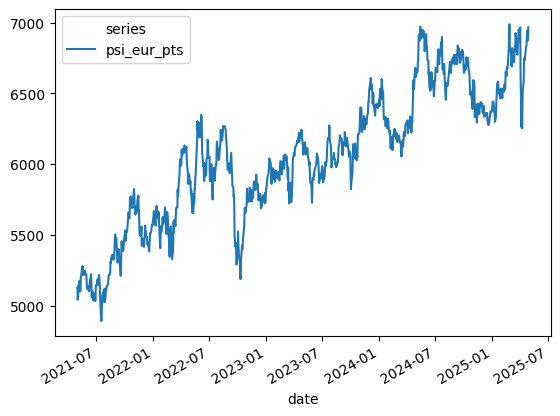

In [21]:
if not combined.empty:
    pivot = combined.pivot(index="date", columns="series", values="value")
    ax = pivot.plot()
    plt.show()
else:
    print("No combined data to plot.")


In [22]:
## Save

out_dir = Path("../data/exogenous/stocks") 
out_dir.mkdir(parents=True, exist_ok=True)

for series_name, df_s in combined.groupby("series", dropna=False):
    # Make a safe filename from the series value
    name = "unknown_series" if pd.isna(series_name) or str(series_name).strip() == "" else str(series_name)
    safe = re.sub(r"[^A-Za-z0-9_.-]+", "_", name).strip("_")
    fp = out_dir / f"{safe}.parquet"

    df_s.sort_values("date").to_parquet(fp, index=False)

# ENTSO-E download: Load Forecast and Interconnection Use



**Range (inclusive): 2021‑05‑21 → 2025‑04‑30**

In [ ]:
# Setup 
import os
from pathlib import Path
import pandas as pd
from entsoe import EntsoePandasClient

# Out path
OUT_DIR = "../data/exogenous/electricity"

# Minimal .env loader (so ../.env works without python-dotenv)
def load_dotenv_simple(path: str = "../.env"):
    p = Path(path)
    if not p.exists():
        return
    for line in p.read_text(encoding="utf-8").splitlines():
        s = line.strip()
        if not s or s.startswith("#") or "=" not in s:
            continue
        k, v = s.split("=", 1)
        k = k.strip()
        v = v.strip().strip('"').strip("'")
        os.environ.setdefault(k, v)

load_dotenv_simple("../.env")



TOKEN = os.environ.get("ENTSOE_API_TOKEN")
assert TOKEN, "Missing ENTSOE_API_TOKEN env var"

epy = EntsoePandasClient(api_key=TOKEN)

TZ = "Europe/Brussels"
START = pd.Timestamp("2021-05-21", tz=TZ)
END_EXCL = pd.Timestamp("2025-05-01", tz=TZ)  # exclusive


In [46]:
# Helpers 
def _to_series(x, value_name="value"):
    # entsoe-py sometimes returns Series, sometimes DataFrame
    if isinstance(x, pd.DataFrame):
        if x.shape[1] == 1:
            s = x.iloc[:, 0]
        else:
            # fallback: take first numeric column
            num_cols = x.select_dtypes("number").columns
            s = x[num_cols[0]] if len(num_cols) else x.iloc[:, 0]
    else:
        s = x
    s = s.dropna()
    s.name = value_name
    return s

def hourly_to_daily_stats(s: pd.Series, tz: str = "Europe/Brussels") -> pd.DataFrame:
    s = s.copy()
    s.index = pd.to_datetime(s.index)
    if s.index.tz is None:
        s.index = s.index.tz_localize("UTC")
    s_local = s.tz_convert(tz)

    df = s_local.to_frame("value")
    df["date_local"] = df.index.date

    out = (
        df.groupby("date_local")["value"]
          .agg(value_mean="mean", value_min="min", value_max="max", n_points="count")
          .reset_index()
    )
    out["energy_mwh"] = df.groupby("date_local")["value"].sum().reindex(out["date_local"]).to_numpy()
    return out



### Download

In [47]:

# --- 1) Load forecast (day-ahead total load forecast) ----------------------
AREAS = ["ES", "FR", "PT"]
TZ = "Europe/Brussels"
load_daily_parts = []

for a in AREAS:
    try:
        raw = epy.query_load_forecast(a, start=START, end=END_EXCL)
        s = _to_series(raw, value_name="mw")
        d = hourly_to_daily_stats(s)
        d.insert(0, "area", a)
        load_daily_parts.append(d)
        print("Load forecast OK:", a, "rows:", len(d))
    except Exception as e:
        print("Load forecast FAILED:", a, "|", repr(e))

load_daily = pd.concat(load_daily_parts, ignore_index=True) if load_daily_parts else pd.DataFrame(
    columns=["area","date_local","value_mean","value_min","value_max","n_points","energy_mwh"]
)



Load forecast OK: ES rows: 1441
Load forecast OK: FR rows: 1441
Load forecast OK: PT rows: 1441


In [48]:

# --- 2) Commercial scheduled exchanges (use of interconnection) ------------
# day-ahead commercial schedules
BORDERS = [("ES", "FR"), ("FR", "ES"), ("ES", "PT"), ("PT", "ES")]
flow_daily_parts = []

for f, t in BORDERS:
    try:
        raw = epy.query_scheduled_exchanges(f, t, start=START, end=END_EXCL, dayahead=True)
        s = _to_series(raw, value_name="mw")
        d = hourly_to_daily_stats(s)
        d.insert(0, "to_area", t)
        d.insert(0, "from_area", f)
        flow_daily_parts.append(d)
        print("Scheduled exchange OK:", f, "->", t, "rows:", len(d))
    except Exception as e:
        print("Scheduled exchange FAILED:", f, "->", t, "|", repr(e))

flow_daily = pd.concat(flow_daily_parts, ignore_index=True) if flow_daily_parts else pd.DataFrame(
    columns=["from_area","to_area","date_local","value_mean","value_min","value_max","n_points","energy_mwh"]
)


Scheduled exchange OK: ES -> FR rows: 1441
Scheduled exchange OK: FR -> ES rows: 1441
Scheduled exchange OK: ES -> PT rows: 1441
Scheduled exchange OK: PT -> ES rows: 1441


In [49]:
# Out path
OUT_DIR = "../data/exogenous/electricity"


# Save 
load_parquet = Path(OUT_DIR) / "entsoe_load_forecast_daily_20210521_20250430.parquet"
flow_parquet = Path(OUT_DIR) / "entsoe_scheduled_exchanges_daily_20210521_20250430.parquet"

load_daily.to_parquet(load_parquet, index=False)
flow_daily.to_parquet(flow_parquet, index=False)

print("\nLoad daily rows:", len(load_daily))
print("Flow daily rows:", len(flow_daily))


Load daily rows: 4323
Flow daily rows: 5764


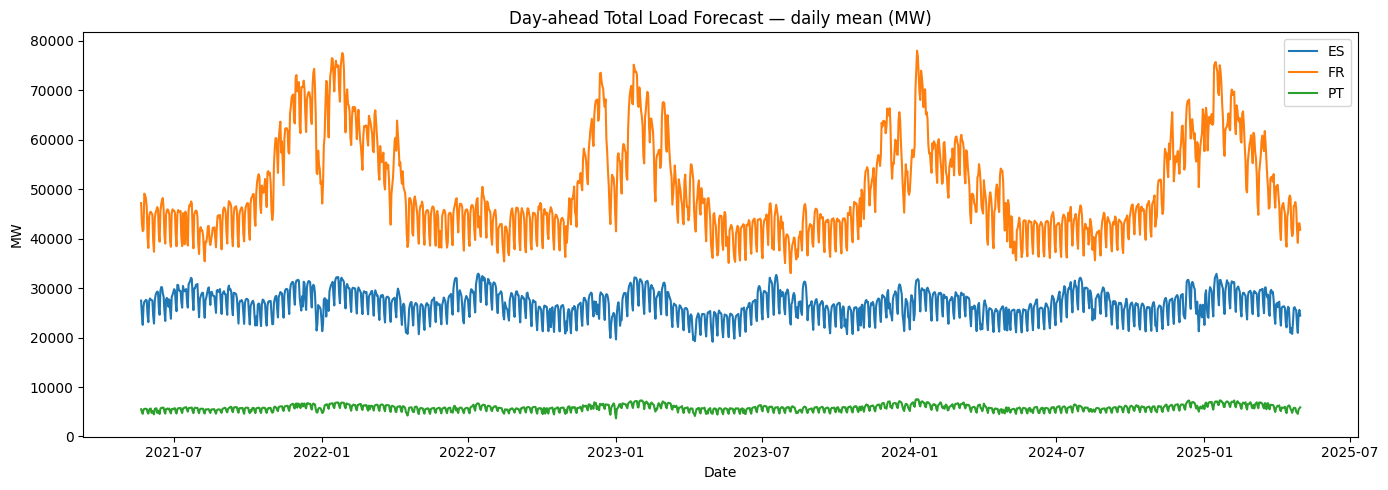

In [50]:
# Ensure datetime
if not load_daily.empty:
    load_daily["date_local"] = pd.to_datetime(load_daily["date_local"])
if not flow_daily.empty:
    flow_daily["date_local"] = pd.to_datetime(flow_daily["date_local"])

# 1) Load forecast (daily mean) — one line per area
if load_daily.empty:
    print("load_daily is empty")
else:
    plt.figure(figsize=(14, 5))
    for area in sorted(load_daily["area"].unique()):
        dfa = load_daily[load_daily["area"] == area].sort_values("date_local")
        plt.plot(dfa["date_local"], dfa["value_mean"], label=area)
    plt.title("Day-ahead Total Load Forecast — daily mean (MW)")
    plt.xlabel("Date")
    plt.ylabel("MW")
    plt.legend()
    plt.tight_layout()
    plt.show()


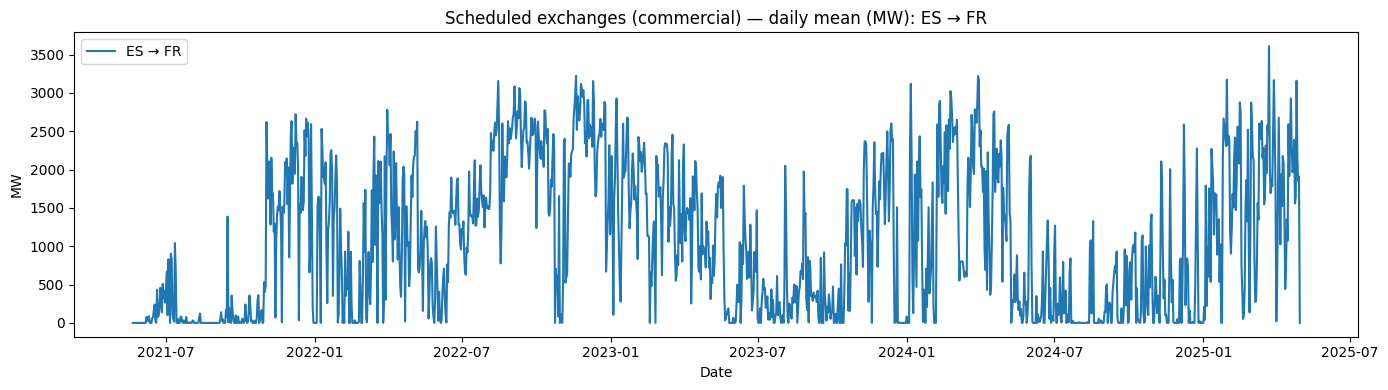

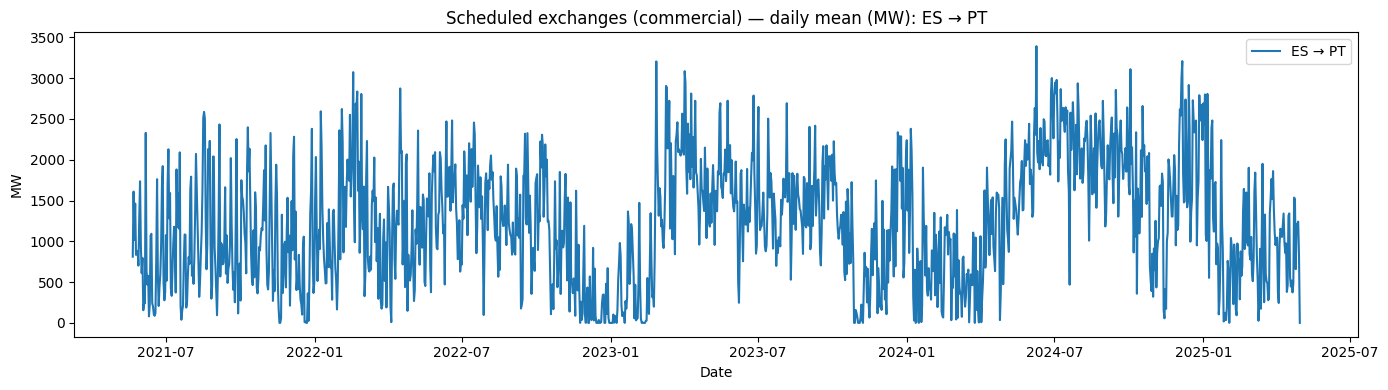

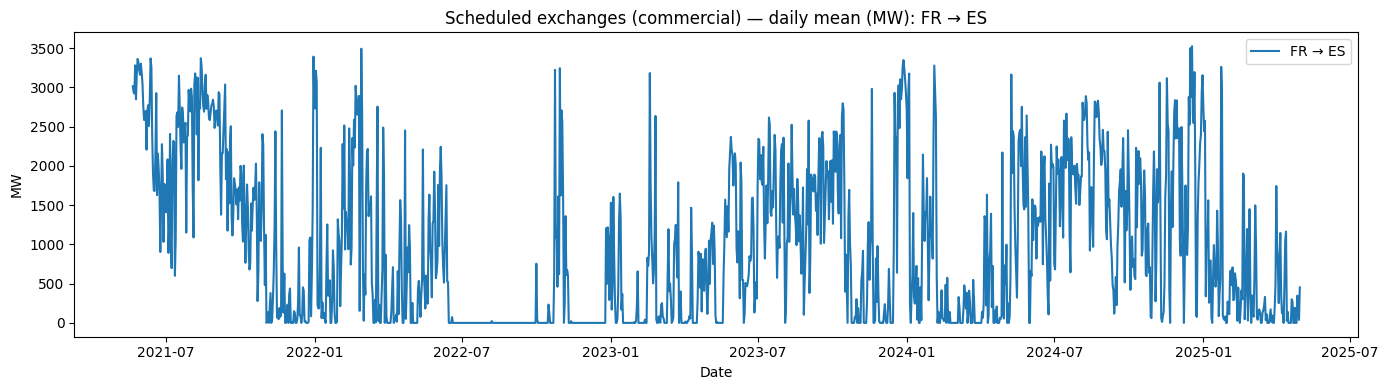

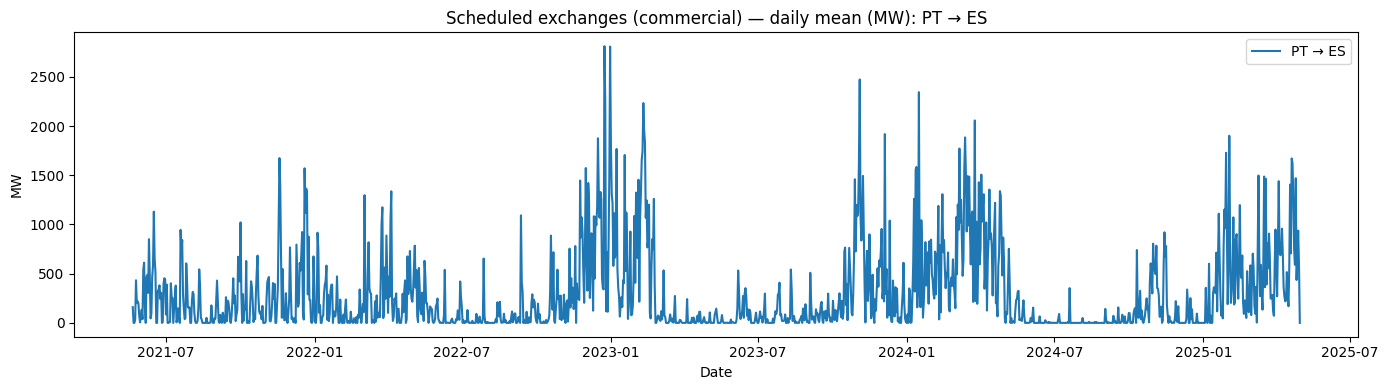

In [51]:

# 2) Scheduled exchanges (daily mean) — one plot per direction
if flow_daily.empty:
    print("flow_daily is empty")
else:
    pairs = (
        flow_daily[["from_area", "to_area"]]
        .drop_duplicates()
        .sort_values(["from_area", "to_area"])
        .to_records(index=False)
    )

    for f, t in pairs:
        dfp = flow_daily[(flow_daily["from_area"] == f) & (flow_daily["to_area"] == t)].sort_values("date_local")
        plt.figure(figsize=(14, 4))
        plt.plot(dfp["date_local"], dfp["value_mean"], label=f"{f} → {t}")
        plt.title(f"Scheduled exchanges (commercial) — daily mean (MW): {f} → {t}")
        plt.xlabel("Date")
        plt.ylabel("MW")
        plt.legend()
        plt.tight_layout()
        plt.show()


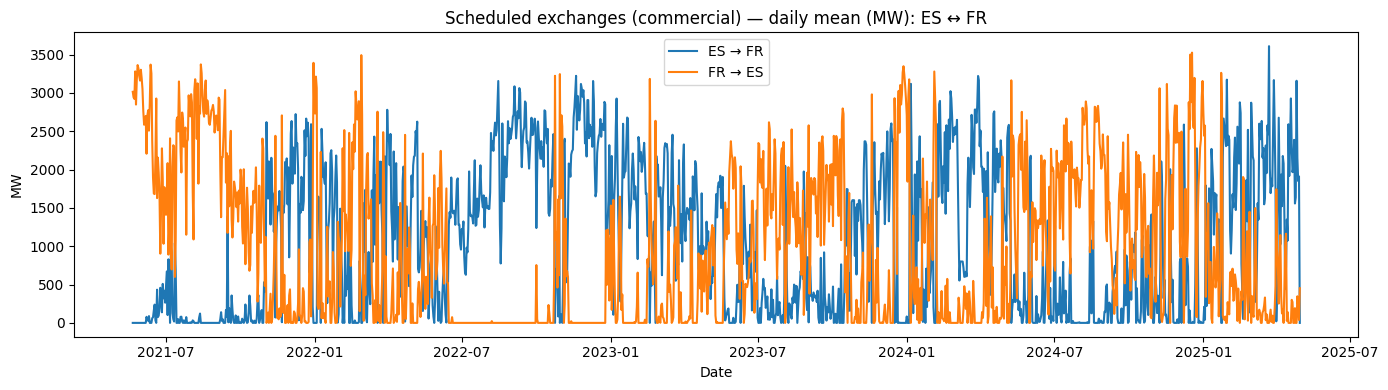

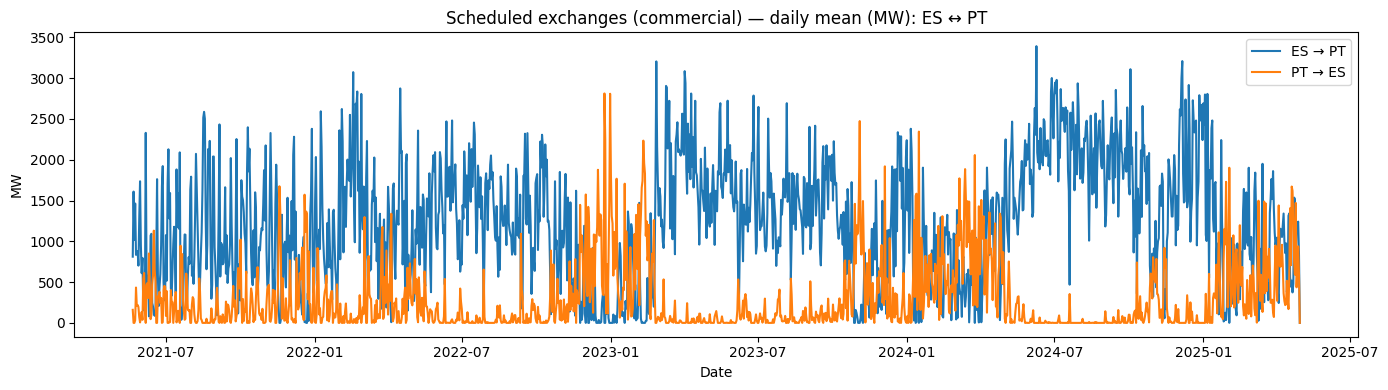

In [52]:

# 3) Scheduled exchanges — both directions on the same plot for each border
if not flow_daily.empty:
    borders = [("ES", "FR"), ("ES", "PT")]
    for a, b in borders:
        d1 = flow_daily[(flow_daily["from_area"] == a) & (flow_daily["to_area"] == b)].sort_values("date_local")
        d2 = flow_daily[(flow_daily["from_area"] == b) & (flow_daily["to_area"] == a)].sort_values("date_local")
        if d1.empty and d2.empty:
            continue

        plt.figure(figsize=(14, 4))
        if not d1.empty:
            plt.plot(d1["date_local"], d1["value_mean"], label=f"{a} → {b}")
        if not d2.empty:
            plt.plot(d2["date_local"], d2["value_mean"], label=f"{b} → {a}")
        plt.title(f"Scheduled exchanges (commercial) — daily mean (MW): {a} ↔ {b}")
        plt.xlabel("Date")
        plt.ylabel("MW")
        plt.legend()
        plt.tight_layout()
        plt.show()

In [54]:
flow_daily.tail()

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "C:\Users\frolo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\IPython\core\formatters.py", line 222, in catch_format_error
    r = method(self, *args, **kwargs)
  File "C:\Users\frolo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\IPython\core\formatters.py", line 343, in __call__
    return method()
  File "C:\Users\frolo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pandas\core\frame.py", line 1175, in _repr_html_
    else:
  File "C:\Users\frolo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pandas\io\formats\format.py", line 1074, in to_html
  File "C:\Users\frolo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0

     from_area to_area date_local  value_mean  value_min  value_max  n_points  \
5759        PT      ES 2025-04-26  436.029167        0.0     1988.8        96   
5760        PT      ES 2025-04-27  681.441667        0.0     2514.2        96   
5761        PT      ES 2025-04-28  937.620833        0.0     3327.0        96   
5762        PT      ES 2025-04-29  589.100000        0.0     2299.3        96   
5763        PT      ES 2025-04-30    0.000000        0.0        0.0        96   

      energy_mwh  
5759     41858.8  
5760     65418.4  
5761     90011.6  
5762     56553.6  
5763         0.0  

## Iberian exception dummy

In [56]:
# Iberian exception dummy (daily)

OUT_DIR = "../data/exogenous/electricity"
Path(OUT_DIR).mkdir(parents=True, exist_ok=True)

# Match project’s daily sample 
sample_start = "2021-05-21"
sample_end   = "2025-04-30"

ie_start = pd.Timestamp("2022-06-15").date()
ie_end   = pd.Timestamp("2023-02-26").date()

dates = pd.date_range(sample_start, sample_end, freq="D").date

df_ie = pd.DataFrame({"date_local": dates})
df_ie["iberian_exception"] = ((df_ie["date_local"] >= ie_start) & (df_ie["date_local"] <= ie_end)).astype(int)

out_path = Path(OUT_DIR) / "iberian_exception.parquet"
df_ie.to_parquet(out_path, index=False)

print("Saved:", out_path)
df_ie.loc[(df_ie["date_local"] >= ie_start) & (df_ie["date_local"] <= ie_end)].head()


Saved: ..\data\exogenous\electricity\iberian_exception.parquet
Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "C:\Users\frolo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\IPython\core\formatters.py", line 222, in catch_format_error
    r = method(self, *args, **kwargs)
  File "C:\Users\frolo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\IPython\core\formatters.py", line 343, in __call__
    return method()
  File "C:\Users\frolo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pandas\core\frame.py", line 1175, in _repr_html_
    else:
  File "C:\Users\frolo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pandas\io\formats\format.py", line 1074, in to_html
  File "C:\Users\frolo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0

     date_local  iberian_exception
390  2022-06-15                  1
391  2022-06-16                  1
392  2022-06-17                  1
393  2022-06-18                  1
394  2022-06-19                  1